In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Locating the FX Spot Data Path
FX_Spot_Data_Path = 'C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_03_08_FX_Parity\\CUQTS-FX-GitHub-Folders\\CUQTS-FX-GitHub-Folders\\Data\\Currency Data'

#Locating the Signal Data Path
Signal_Path = 'C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_03_08_FX_Parity\\CUQTS-FX-GitHub-Folders\\CUQTS-FX-GitHub-Folders\\Result'

In [3]:
signal_df = pd.read_csv(Signal_Path + '\\IRP\\USDJPY\\Data Details' + '\\' + '3M.csv', index_col = 0)

In [46]:
#Setting the Currency Pair Set
curr = ["USD", "JPY", "GBP", "CHF","EUR"]
gen = ((x,y) for x in curr for y in curr)
curr_pair_set = []

for xxx, yyy in gen:
        
        if xxx == yyy :
            continue
        try:
            FX_Spot_df = pd.read_csv(FX_Spot_Data_Path + '\\' + xxx+yyy + '.csv', index_col = 0, header = 1)
        except:
            continue
            
        curr_pair_set.append(xxx+yyy)
        
#curr_pair_set = ['USDEUR','USDGBP', 'USDJPY', 'USDCHF']

#Setting the timeframe Set
tf_set = ['1M', '3M']

#Setting the target parity

parity = 'PPP'

In [5]:
G_10 = ["USD", "JPY", "GBP", "CHF","EUR"]
treasury_dict = {}

for currency in G_10:
    treasury_data_df = pd.read_csv('C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_04_03\\Data\\overnight_rate\\' 
                                        + currency + '.csv', header = 1, index_col = 0)
    treasury_dict[currency] = pd.DataFrame(treasury_data_df['last_price'].dropna())

In [13]:
#Setting the Hyperparameter for the backtesting

#Transaction Cost
transaction_cost = 0
carry_trade_cost = 0

#Signal Threshold
signal_threshold = 0

#Setting the trading window length
trading_window_basket = range(1,6)

#Control of whether trading cost and carry trade is consider
with_in_interest_rate = True

# Helper Function Section

In [7]:
#defining the helper function for computing the signal end date

def trade_unwind_date(signal_date, trading_window):
    start_date_timestramp = pd.to_datetime(signal_date, format = '%Y-%m-%d')
    date_delta = pd.tseries.offsets.BusinessDay(n=trading_window)
    end_date_timestramp = start_date_timestramp + date_delta
    return str(end_date_timestramp.date())

In [8]:
# Defining Helper Function to Compute the Actual Interest Rate Count

def searching_interest_rate_maturity(currency):
    Maturity = ['1M', '3M', '6M', '1Y']
    for maturity in Maturity:
        if treasury_dict[currency+'_'+maturity] is None:
            continue
        else:
            return maturity
        return None

def actual_interest_rate_count(start_date, end_date, currency, maturity):
    start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')
    actual = (end_date_dt - start_date_dt).days
    if currency == 'USD' or currency == 'EUR' or currency == 'CHF':
        return actual/360
    if currency == 'GBP' and maturity == '1Y':
        return 1
    if currency == 'AUD' and maturity == '1Y':
        return 1
    if currency == 'JPY' and maturity == '1Y':
        try : 
            if start_date[5:7] > '02':
                dt_3 = datetime.datetime.strptime(end_date[0:4] + '-02-29', '%Y-%m-%d')
            else : 
                dt_3 = datetime.datetime.strptime(start_date[0:4] + '-02-29', '%Y-%m-%d')
            return (actual-1)/365
        except : 
            return actual/365
    if currency == 'SEK':
        if maturity == '1Y':
            return 1
        else:
            return actual/360
                
    return actual/365

def day_count_convention(currency):
    if currency in ['JPY', 'GBP', 'NZD']:
        return 1/365
    else:
        return 1/360

def carry_trade_benefit_and_cost(trade_date_list, currency):
    
    treasury_data = treasury_dict[currency]
    day_count = day_count_convention(currency)
    start_date = trade_date_list[0]
    
    if len(treasury_data.index[treasury_data.index <=start_date]) == 0 or len(treasury_data.index[treasury_data.index >=start_date]) == 0:
        return 1
    
    carry_trade_factor = 1
    
    for date in trade_date_list:
        
        if len(treasury_data[treasury_data.index>date]) == 0:
            return 1
        
        next_trading_date = treasury_data[treasury_data.index>date].iloc[0][0]
        
        if (datetime.strptime(date, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d") != next_trading_date :
            flag = False
        else:
            flag = True
        
        carry_trade_factor = carry_trade_factor*(1+treasury_data[treasury_data.index <=date].iloc[-1][0]*day_count/100) \
                             if flag else carry_trade_factor*(1+treasury_data[treasury_data.index <=date].iloc[-1][0]*day_count/100 * 3)

    return  carry_trade_factor

In [9]:
#defining the helper functions to compute the performance metrics

def yearly_avg_ret(trading_signal_df):
            
    return (np.mean(return_ls) * 252)

def yearly_avg_vol(trading_signal_df):
    
    return_ls = trading_signal_df['ret'].tolist()
            
    return (np.std(return_ls)**(np.sqrt(252)))

def benchmark_performance(trading_signal_df, curr):
    
    trading_date_ls = trading_signal_df['trading_date'].tolist()
    benchmark_daily_performance_ls = []
    
    prev_date = trading_date_ls[0]
    
    for curr_date in trading_date_ls[1:]:
        
        benchmark_daily_pnl = carry_trade_benefit_and_cost([prev_date], curr)-1
        benchmark_daily_performance_ls.append(benchmark_daily_pnl)
    
    benchmark_daily_performance_ls.insert(0,1)
    
    return benchmark_daily_performance_ls

def annualized_sharpe(trading_signal_df):
    
    annualized_ret = yearly_avg_ret(trading_signal_df)
    annualized_vol = yearly_avg_vol(trading_signal_df)
    
    benchmark_performance_ls = benchmark_performance(trading_signal_df, 'USD')
    benchmark_performance_df = pd.DataFrame()
    benchmark_performance_df['ret'] = benchmark_performance_ls
    
    benchmark_ret = yearly_avg_ret(benchmark_performance_df)
    
    return ((annualized_ret-benchmark_ret)/annualized_vol)

def annualized_alpha(trading_signal_df, benchmark_daily_ret_ls):
    
    start_annualized_ret = yearly_avg_ret(trading_signal_df)
    benchmark_annualized_ret = np.mean(benchmark_daily_ret_ls) * 252
    
    return (start_annualized_ret - benchmark_annualized_ret)
    

def num_of_trading_signal(trading_signal_df):
    
    signal_ls = trading_signal_df['signal'].tolist()
    
    trade_count = 0
    
    for index in range(1,len(signal_ls)):
        
        if signal_ls[index] != 0  and signal_ls[index-1] == 0:
            trade_count += 1
            
    return trade_count

def long_rate(trading_signal_df):
    
    num_of_trade = num_of_trading_signal(trading_signal_df)
    signal_ls = trading_signal_df['signal'].tolist()
    
    long_count = 0 
    
    for index in range(1,len(signal_ls)):
        
        if signal_ls[index] == 1  and signal_ls[index-1] == 0:
            long_count += 1
            
    return long_count/num_of_trade

def win_rate(trading_signal_df):
    
    trade_count = 0
    win_count = 0
    
    period_return_ls = []
    
    for curr_date in trading_signal_df['trading_date']:
        
        if trading_signal_df['signal'][curr_date] != 0:
            period_return_ls.append(trading_signal_df['ret'][curr_date])
        elif len(period_return_ls) == 0:
            continue
        else:
            trade_count += 1
            
            cumret = np.cumprod(np.array(period_return_ls)+1)[-1] - 1
            
            if cumret >0 :
                win_count += 1
                
            period_return_ls = []
            
    return win_count/trade_count
            

In [10]:
def benchmark_portfolio_performance(trading_signal_df, base_curr, pricing_curr, with_in_interest_rate):
    
    if not with_in_interest_rate:
        return [0] * len(trading_signal_df)
    
    base_curr_ret = benchmark_performance(trading_signal_df, base_curr)
    pricing_curr_ret = benchmark_performance(trading_signal_df, pricing_curr)
    
    base_curr_cumret = np.cumprod(np.array(base_curr_ret)+1)
    pricing_curr_cumret = np.cumprod(np.array(pricing_curr_ret)+1)
    
    portfolio_cumret = 0.5 * (base_curr_cumret + pricing_curr_cumret)
    
    portfolio_ret = np.log((portfolio_cumret[1:]/portfolio_cumret[:-1])).tolist()
    
    portfolio_ret.insert(0,1)
    
    return portfolio_ret

# Backtest Logic

testing: USDJPY _ 1
testing: USDJPY _ 2
testing: USDJPY _ 3
testing: USDJPY _ 4
testing: USDJPY _ 5
testing: USDGBP _ 1
testing: USDGBP _ 2
testing: USDGBP _ 3
testing: USDGBP _ 4
testing: USDGBP _ 5
testing: USDCHF _ 1
testing: USDCHF _ 2
testing: USDCHF _ 3
testing: USDCHF _ 4
testing: USDCHF _ 5
testing: USDEUR _ 1
testing: USDEUR _ 2
testing: USDEUR _ 3
testing: USDEUR _ 4
testing: USDEUR _ 5
testing: JPYCHF _ 1
testing: JPYCHF _ 2
testing: JPYCHF _ 3
testing: JPYCHF _ 4
testing: JPYCHF _ 5
testing: GBPJPY _ 1
testing: GBPJPY _ 2
testing: GBPJPY _ 3
testing: GBPJPY _ 4
testing: GBPJPY _ 5
testing: GBPCHF _ 1
testing: GBPCHF _ 2
testing: GBPCHF _ 3
testing: GBPCHF _ 4
testing: GBPCHF _ 5
testing: GBPEUR _ 1
testing: GBPEUR _ 2
testing: GBPEUR _ 3
testing: GBPEUR _ 4
testing: GBPEUR _ 5
testing: EURJPY _ 1
testing: EURJPY _ 2
testing: EURJPY _ 3
testing: EURJPY _ 4
testing: EURJPY _ 5
testing: EURCHF _ 1
testing: EURCHF _ 2
testing: EURCHF _ 3
testing: EURCHF _ 4
testing: EURCHF _ 5


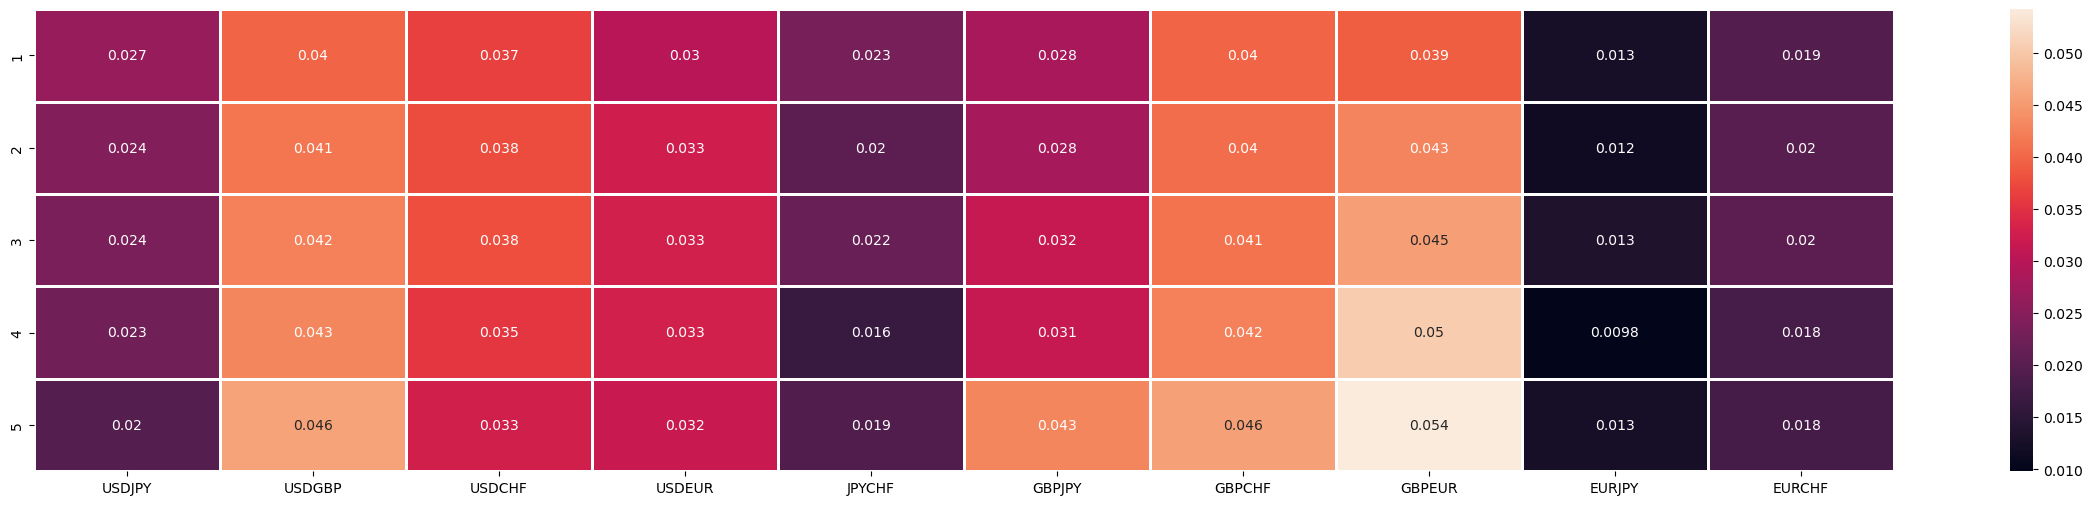

Annualized Alpha


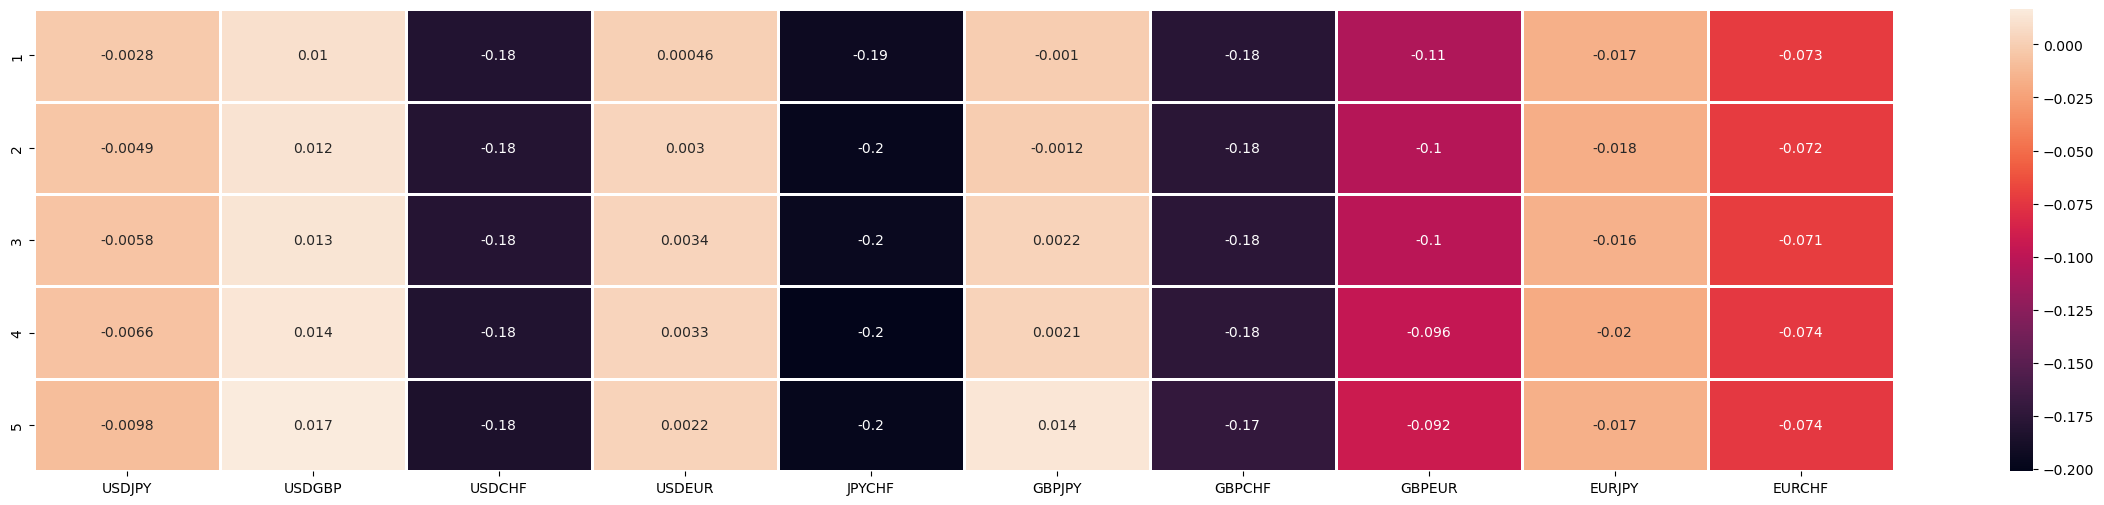

Annualized Sharpe


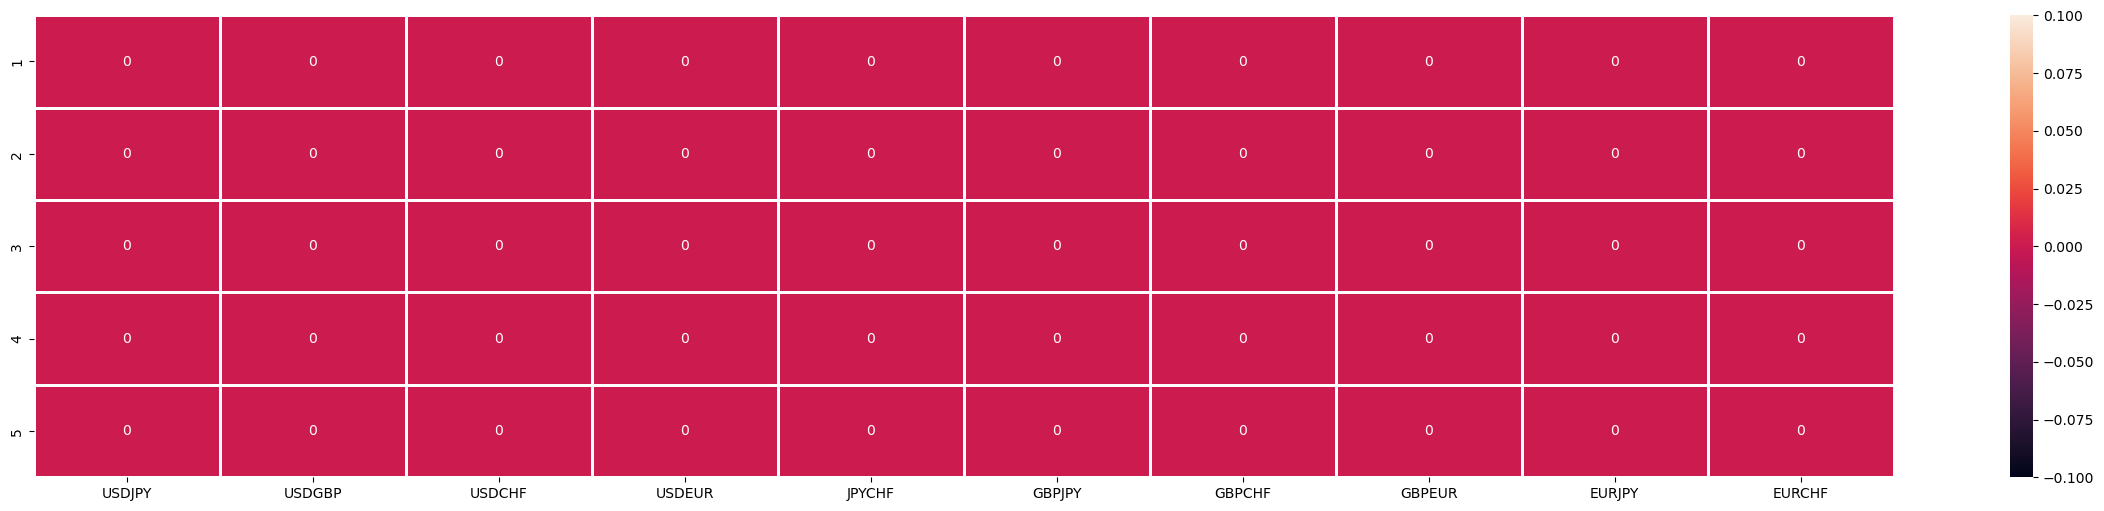

testing: USDJPY _ 1
testing: USDJPY _ 2
testing: USDJPY _ 3
testing: USDJPY _ 4
testing: USDJPY _ 5
testing: USDGBP _ 1
testing: USDGBP _ 2
testing: USDGBP _ 3
testing: USDGBP _ 4
testing: USDGBP _ 5
testing: USDCHF _ 1
testing: USDCHF _ 2
testing: USDCHF _ 3
testing: USDCHF _ 4
testing: USDCHF _ 5
testing: USDEUR _ 1
testing: USDEUR _ 2
testing: USDEUR _ 3
testing: USDEUR _ 4
testing: USDEUR _ 5
testing: JPYCHF _ 1
testing: JPYCHF _ 2
testing: JPYCHF _ 3
testing: JPYCHF _ 4
testing: JPYCHF _ 5
testing: GBPJPY _ 1
testing: GBPJPY _ 2
testing: GBPJPY _ 3
testing: GBPJPY _ 4
testing: GBPJPY _ 5
testing: GBPCHF _ 1
testing: GBPCHF _ 2
testing: GBPCHF _ 3
testing: GBPCHF _ 4
testing: GBPCHF _ 5
testing: GBPEUR _ 1
testing: GBPEUR _ 2
testing: GBPEUR _ 3
testing: GBPEUR _ 4
testing: GBPEUR _ 5
testing: EURJPY _ 1
testing: EURJPY _ 2
testing: EURJPY _ 3
testing: EURJPY _ 4
testing: EURJPY _ 5
testing: EURCHF _ 1
testing: EURCHF _ 2
testing: EURCHF _ 3
testing: EURCHF _ 4
testing: EURCHF _ 5


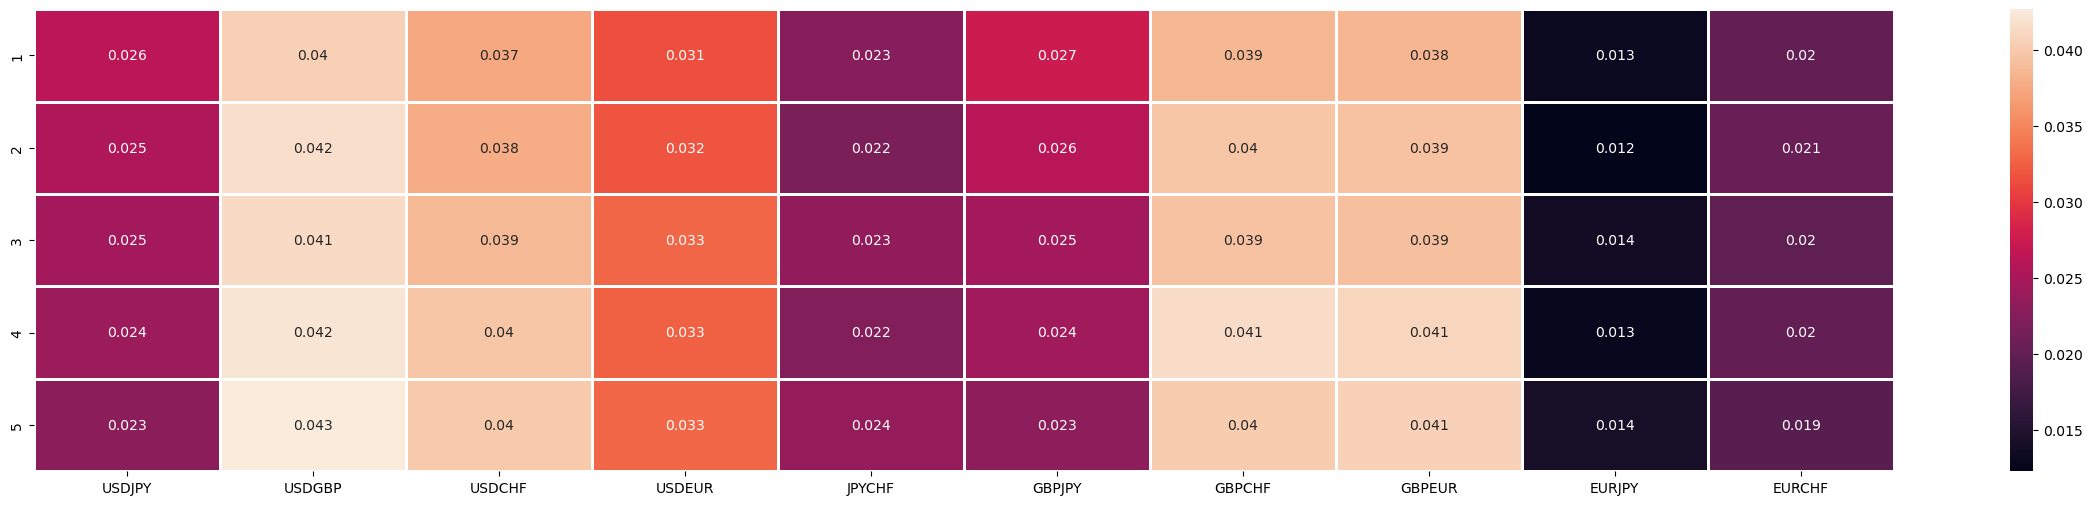

Annualized Alpha


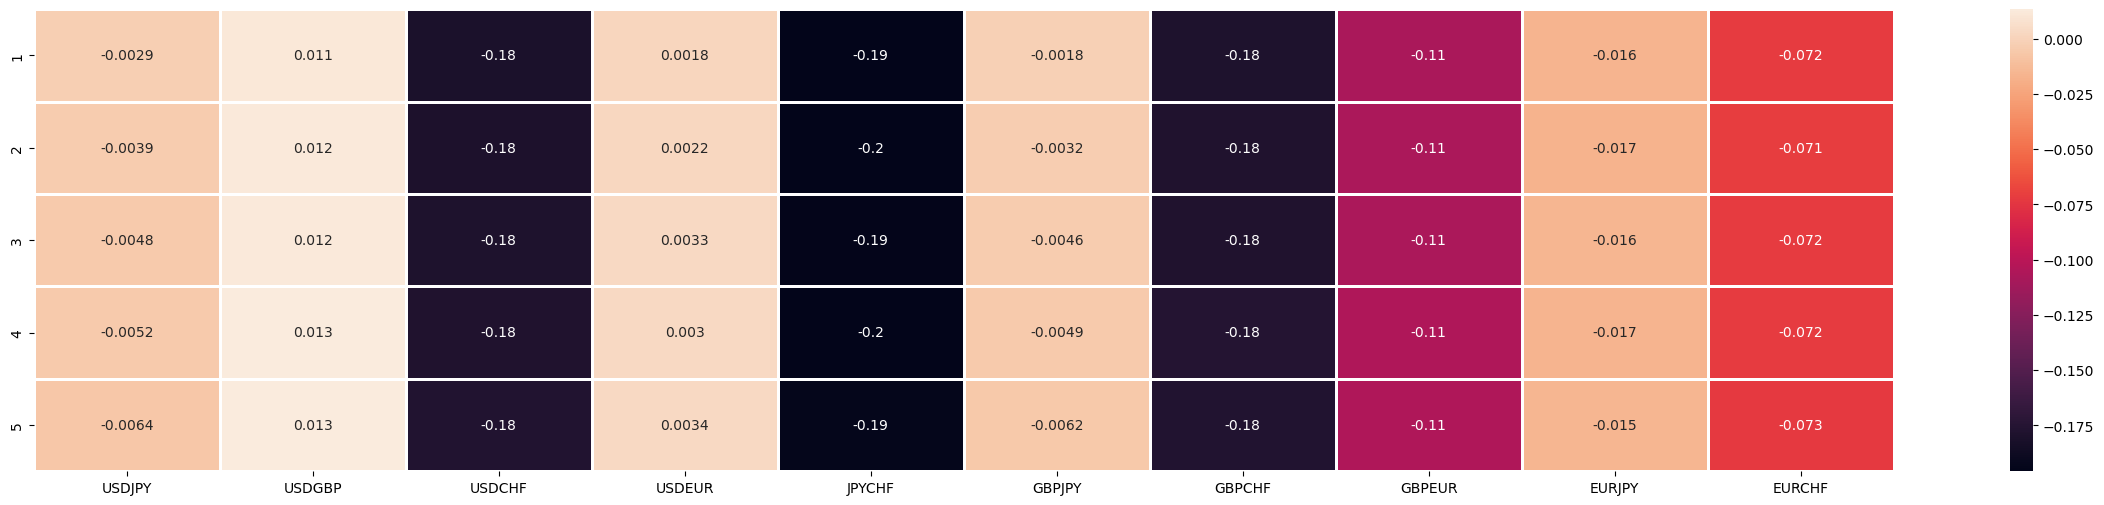

Annualized Sharpe


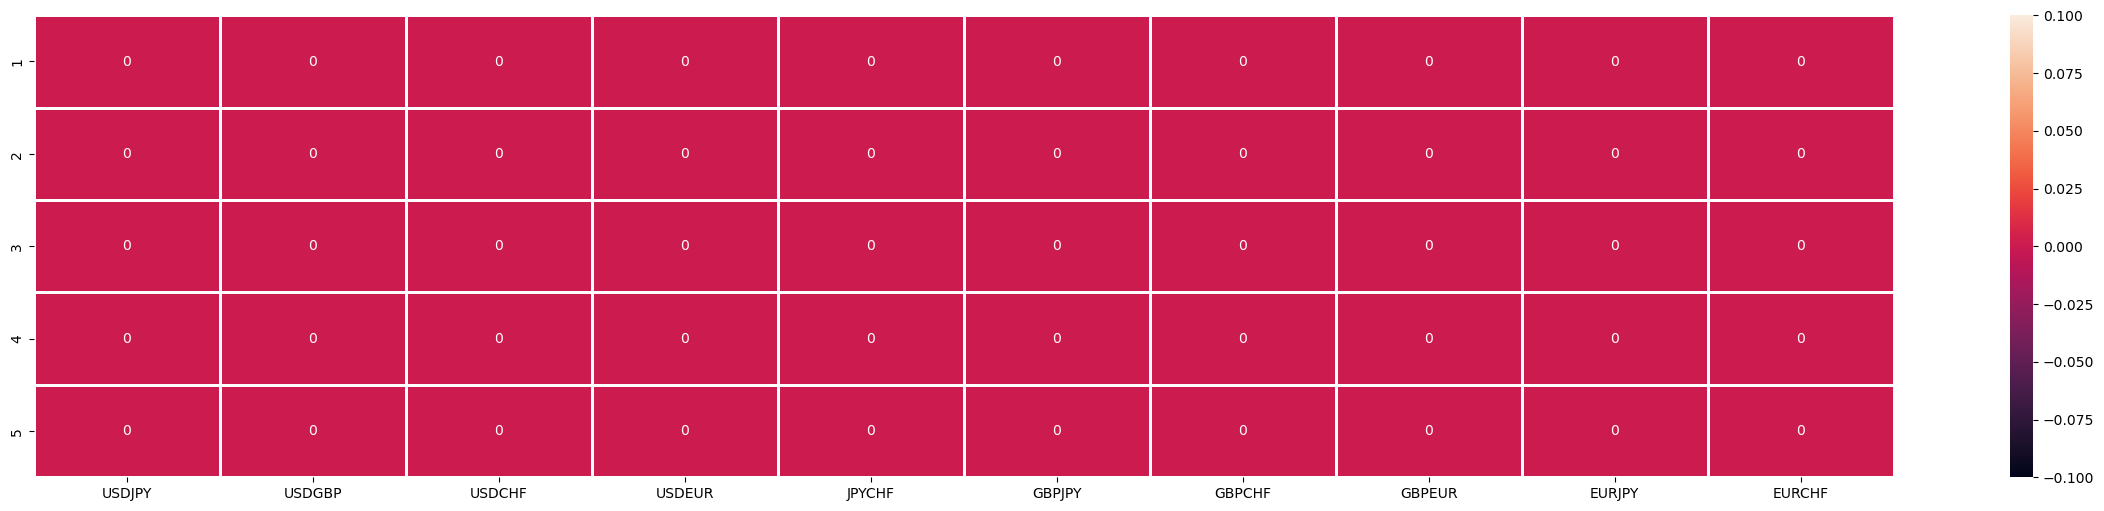

In [47]:
performance_dict_df_by_tf = {}
daily_ret_series_by_tf = {}

for tf in tf_set:

    annualized_ret_df = pd.DataFrame()
    annualized_alpha_df = pd.DataFrame()
    annualized_sharpe_df = pd.DataFrame()
    performance_dict_df = pd.DataFrame()
    dailt_ret_series_by_curr = {}
    
    for curr_pair in curr_pair_set:
        
        annualized_ret_ls = []
        annualized_alpha_ls = []
        annualized_sharpe_ls = []
        performance_dict_ls = []
        dailt_ret_series_by_window = {}
        
        FX_Spot_df = pd.read_csv(FX_Spot_Data_Path + '\\' + curr_pair + '.csv', index_col = 0, header = 1)
        
        try:
            signal_df = pd.read_csv(Signal_Path+'\\'+parity+'\\'+ curr_pair +'\\'+ 'Data Details' + '\\' + tf + '.csv', index_col = 0)
            signal_df.index = signal_df['end_date'].tolist()
        except:
            continue
            
        base_curr = curr_pair[:3]
        pricing_curr = curr_pair[3:]
        
        for trading_window in trading_window_basket:
            
            print('testing:',curr_pair, '_', trading_window)
            
            prev_date = ""
            
            trading_date_ls = []
            signal_ls = []
            base_curr_return_ls = []
            pricing_curr_return_ls = []
            
            signal = 0
            trading_flag = False
            base_converted_cost = 0
            pricing_converted_cost = 0
            interest_rate_factor = 1
            unwind_date = ""
            
            for curr_date in FX_Spot_df.index.tolist():
                
                # checking whether curr date stand adter the first signal date
                if curr_date < signal_df['end_date'][0]:
                    prev_date = curr_date
                    continue
                
                trading_date_ls.append(curr_date) 
                
                # computing the daily PnL
                if not trading_flag:
                    # if not in trade, we earn nothing or interest (based on flag)
                    
                    base_curr_return = carry_trade_benefit_and_cost([prev_date], base_curr) - 1 \
                                       if with_in_interest_rate else 0
                    
                    pricing_curr_return = carry_trade_benefit_and_cost([prev_date], pricing_curr) - 1 \
                                       if with_in_interest_rate else 0
                    
                    
                else:
                    #computing the daily performance if we are in trade
                    if signal == 1:
                        
                        base_curr_return = carry_trade_benefit_and_cost([prev_date], base_curr) - 1 \
                                       if with_in_interest_rate else 0
                        
                        pricing_curr_return = pricing_converted_cost * interest_rate_factor / (1/FX_Spot_df.loc[curr_date][0])
                        
                        pricing_curr_return = pricing_curr_return/(pricing_curr_return_ls[-1]+1)-1 if len(pricing_curr_return_ls) > 0 else pricing_curr_return-1 
                        
                        if with_in_interest_rate:
                            interest_rate_factor *= carry_trade_benefit_and_cost([curr_date], base_curr)
                    
                    else :
                        
                        base_curr_return = base_converted_cost * interest_rate_factor / FX_Spot_df.loc[curr_date][0]
                        
                        base_curr_return = base_curr_return/(base_curr_return_ls[-1]+1)-1 if len(base_curr_return_ls) > 0 else base_curr_return -1
                        
                        pricing_curr_return = carry_trade_benefit_and_cost([prev_date], pricing_curr) - 1 \
                                       if with_in_interest_rate else 0

                        
                        if with_in_interest_rate:
                            interest_rate_factor *= carry_trade_benefit_and_cost([curr_date], pricing_curr)
                    
                        
                base_curr_return_ls.append(base_curr_return)
                pricing_curr_return_ls.append(pricing_curr_return)
                        
                signal_ls.append(signal)
                    
                        
                # check whether we have signal or we reach unwind date
                if curr_date not in signal_df['end_date'] :
                    
                    if curr_date == unwind_date:
                        signal = 0
                        trading_flag = False
                        base_converted_cost = 0
                        pricing_converted_cost = 0
                        interest_rate_factor = 1
                        unwind_date = ""
                    prev_date = curr_date
                    continue
                    
                else:
                    # curr date has signal
                    signal = np.sign(signal_df['spot_error_pct'][curr_date]) * -1
                    trading_flag = True
                    
                    # determine the unwind_date
                    unwind_date = trade_unwind_date(curr_date, trading_window)
                    
                    flag = False
                    count = 0
                    while (not flag):
                        try:
                            end_spot = FX_Spot_df.loc[unwind_date][0]
                            flag = True
                        except:
                            unwind_date = trade_unwind_date(unwind_date, 1)
                            count += 1
                            if count == 6:
                                break
                                
                    if not flag:
                        signal = 0
                        trading_flag = False
                        prev_date = curr_date
                        continue
                        
                    if signal == 1:
                        pricing_converted_cost = 1/FX_Spot_df.loc[curr_date][0]
                        if with_in_interest_rate:
                            interest_rate_factor *= carry_trade_benefit_and_cost([curr_date], base_curr)
                    else:
                        base_converted_cost = FX_Spot_df.loc[curr_date][0]
                        if with_in_interest_rate:
                            interest_rate_factor *= carry_trade_benefit_and_cost([curr_date], pricing_curr)   
                    
                    prev_date = curr_date
                
            
            if len(trading_date_ls) > 0:
                
                #preparing for the performance metrics
                trading_signal_df=pd.DataFrame()
                trading_signal_df["trading_date"] = trading_date_ls
                trading_signal_df.index = trading_date_ls
                trading_signal_df["signal"] = signal_ls
                
                cumret = 0.5 * (np.cumprod(np.array(base_curr_return_ls) + 1) + np.cumprod(np.array(pricing_curr_return_ls) + 1))
                return_ls = np.log(cumret[1:]/cumret[:-1]).tolist()
                return_ls.insert(0,(base_curr_return_ls[0]+pricing_curr_return_ls[0])*0.5)
                
                trading_signal_df["ret"] = return_ls
                
                #computing the benchmark return
                benchmark_daily_ret_ls = benchmark_portfolio_performance(trading_signal_df, base_curr, pricing_curr, with_in_interest_rate)
                
                performance_dict = {}
                performance_dict["yearly_avg_ret"] = yearly_avg_ret(trading_signal_df)
                performance_dict["yearly_avg_vol"] = yearly_avg_vol(trading_signal_df)
                performance_dict["Sharpe"] = annualized_sharpe(trading_signal_df)
                performance_dict["Alpha"] = annualized_alpha(trading_signal_df, benchmark_daily_ret_ls)
                performance_dict["Number_of_Signal"] = num_of_trading_signal(trading_signal_df)
                performance_dict["Long_Signal_Rate"] = long_rate(trading_signal_df)
                performance_dict["Win_Rate"] = win_rate(trading_signal_df)
                
                performance_dict_ls.append(performance_dict)
                
                #storing the daily ret series
                daily_ret_df = pd.DataFrame()
                daily_ret_df['strat'] =  return_ls
                daily_ret_df['benchmark'] = benchmark_daily_ret_ls
                daily_ret_df.index = trading_signal_df.index
                dailt_ret_series_by_window[trading_window] = daily_ret_df
                
                annualized_ret_ls.append(performance_dict["yearly_avg_ret"])
                annualized_alpha_ls.append(performance_dict["Alpha"])
                annualized_sharpe_ls.append(performance_dict["Sharpe"])

            else:
                annualized_ret_ls.append(np.nan)
                annualized_alpha_ls.append(np.nan)
                annualized_sharpe_ls.append(np.nan)
                performance_dict_ls.append(np.nan)
                dailt_ret_series_by_window[trading_window] = np.nan
                
        annualized_ret_df[curr_pair] = annualized_ret_ls
        annualized_alpha_df[curr_pair] = annualized_alpha_ls
        annualized_sharpe_df[curr_pair] = annualized_sharpe_ls
        performance_dict_df[curr_pair] = performance_dict_ls
        dailt_ret_series_by_curr[curr_pair] = dailt_ret_series_by_window
    
    print('Annualized Return')
    annualized_ret_df.index = trading_window_basket
    plt.figure(figsize=(30,6))
    sns.heatmap(annualized_ret_df, annot=True, linewidths=1)
    plt.show()
    
    print('Annualized Alpha')
    annualized_alpha_df.index = trading_window_basket
    plt.figure(figsize=(30,6))
    sns.heatmap(annualized_alpha_df, annot=True, linewidths=1)
    plt.show()
    
    print('Annualized Sharpe')
    annualized_sharpe_df.index = trading_window_basket
    plt.figure(figsize=(30,6))
    sns.heatmap(annualized_sharpe_df, annot=True, linewidths=1)
    plt.show()
    
    
    performance_dict_df.index = trading_window_basket
    performance_dict_df_by_tf[tf] = performance_dict_df
    daily_ret_series_by_tf[tf] = dailt_ret_series_by_curr
    

# Performance Overview

In [80]:
#Please Enter tf and curr_pair

tf = '1M'
curr_pair = 'USDGBP'

#Extracting the performance metric
performance_dict_df = performance_dict_df_by_tf[tf]

for index in performance_dict_df.index:
    
    print("Trading Window : ", index)
    print(performance_dict_df[curr_pair].iloc[index-1])

Trading Window :  1
{'yearly_avg_ret': -0.0008333577493515029, 'yearly_avg_vol': 0.005175198314536893, 'Number_of_Signal': 79, 'Long_Signal_Rate': 0.5443037974683544, 'Win_Rate': 0.43037974683544306}
Trading Window :  2
{'yearly_avg_ret': -5.5514488423096934e-05, 'yearly_avg_vol': 0.008867683302249458, 'Number_of_Signal': 79, 'Long_Signal_Rate': 0.5443037974683544, 'Win_Rate': 0.43037974683544306}
Trading Window :  3
{'yearly_avg_ret': 0.0011914218209601705, 'yearly_avg_vol': 0.011371746726588253, 'Number_of_Signal': 79, 'Long_Signal_Rate': 0.5443037974683544, 'Win_Rate': 0.5189873417721519}
Trading Window :  4
{'yearly_avg_ret': 0.0006541021483914228, 'yearly_avg_vol': 0.01140833414785882, 'Number_of_Signal': 79, 'Long_Signal_Rate': 0.5443037974683544, 'Win_Rate': 0.45569620253164556}
Trading Window :  5
{'yearly_avg_ret': 0.0006921760181173312, 'yearly_avg_vol': 0.013450817233906795, 'Number_of_Signal': 79, 'Long_Signal_Rate': 0.5443037974683544, 'Win_Rate': 0.46835443037974683}
